In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import sys
dir_path = '/content/gdrive/MyDrive/DL/'
sys.path.append(dir_path)

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 880 kB 51.3 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 596 kB 56.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f76b35ea40dd9424873fdac249386b829e66f9ea4530780e87bf47e34dfd2782
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torch-summary --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import datetime

In [ ]:
df = pd.read_json('/content/gdrive/MyDrive/DL/dataset/data.jsonl', lines=True)

In [ ]:
df['idx'] = df['idx'].astype(int)

In [ ]:
df = df.set_index('idx')

In [ ]:
df.head()

,func
idx,
10000832,public static void main(String[] args) {\n...
10005623,public synchronized String getSerialNumber...
10005624,public Object run() {\n ...
10005674,public String post() {\n if (conten...
10005879,@Override\n public void onCreate(Bundle...


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/DL/dataset/train.txt', sep='\t', header=None, names=['idx1', 'idx2', 'label'])

In [ ]:
train_df['idx1'] = train_df['idx1'].astype(int)
train_df['idx2'] = train_df['idx2'].astype(int)
train_df['label'] = train_df['label'].astype(int)

In [ ]:
train_df.head()

,idx1,idx2,label
0,13988825,8660836,0
1,80378,18548122,1
2,21354223,7421563,1
3,15826299,19728871,0
4,9938081,11517213,0


In [ ]:
print(train_df.shape)

(901028, 3)


In [ ]:
train_df = train_df.sample(n=5000, ignore_index=True)

In [ ]:
print(train_df.shape)

(5000, 3)


In [ ]:
train_df['label'].value_counts()

0    2576
1    2424
Name: label, dtype: int64

In [ ]:
val_df = pd.read_csv('/content/gdrive/MyDrive/DL/dataset/valid.txt', sep='\t', header=None, names=['idx1', 'idx2', 'label'])

In [ ]:
val_df['idx1'] = val_df['idx1'].astype(int)
val_df['idx2'] = val_df['idx2'].astype(int)
val_df['label'] = val_df['label'].astype(int)

In [ ]:
val_df.head()

,idx1,idx2,label
0,13653451,21955002,0
1,1188160,8831513,0
2,1141235,14322332,0
3,16765164,17526811,0
4,12442447,390730,0


In [ ]:
print(val_df.shape)

(415416, 3)


In [ ]:
val_df = val_df.sample(n=1000, ignore_index=True)

In [ ]:
print(val_df.shape)

(1000, 3)


In [ ]:
test_df = pd.read_csv('/content/gdrive/MyDrive/DL/dataset/test.txt', sep='\t', header=None, names=['idx1', 'idx2', 'label'])

In [ ]:
test_df['idx1'] = test_df['idx1'].astype(int)
test_df['idx2'] = test_df['idx2'].astype(int)
test_df['label'] = test_df['label'].astype(int)

In [ ]:
test_df.head()

,idx1,idx2,label
0,2381663,4458076,0
1,3809087,15757836,0
2,6987642,4921631,0
3,21316706,4168534,0
4,4798332,1473212,0


In [ ]:
print(test_df.shape)

(415416, 3)


In [ ]:
test_df = test_df.sample(n=1000, ignore_index=True)

In [ ]:
print(test_df.shape)

(1000, 3)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/graphcodebert-base") 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

In [ ]:
df['code_tokens'] = df['func'].apply(tokenizer.tokenize)

In [ ]:
df['code_token_len'] = df['code_tokens'].apply(lambda x: len(x))

In [ ]:
max_length = int(df['code_token_len'].quantile(0.7))

In [ ]:
print(max_length)

724


In [ ]:
def tokenize_function(values):
  return tokenizer(values, max_length=max_length, padding='max_length', truncation=True)['input_ids']

In [ ]:
df['code_tokens'] = df['func'].apply(tokenize_function)

In [ ]:
df['code_tokens'].sample(n=10)

idx
13871052    [0, 1437, 1437, 1437, 285, 49378, 7511, 47279,...
13354574    [0, 1437, 1437, 1437, 940, 25156, 289, 48741, ...
23267978    [0, 1437, 1437, 1437, 285, 25156, 49378, 5375,...
2278820     [0, 1437, 1437, 1437, 285, 26602, 46627, 245, ...
9350616     [0, 1437, 1437, 1437, 787, 49116, 50118, 1437,...
6744825     [0, 1437, 1437, 1437, 940, 25156, 26602, 120, ...
6780166     [0, 1437, 1437, 1437, 285, 25156, 13842, 5375,...
20696811    [0, 1437, 1437, 1437, 940, 25156, 49378, 11, 1...
6503552     [0, 1437, 1437, 1437, 285, 25156, 5423, 46331,...
8725960     [0, 1437, 1437, 1437, 940, 46123, 47952, 4686,...
Name: code_tokens, dtype: object

In [ ]:
df = df.drop(columns=['code_token_len'])

In [ ]:
df.head()

,func,code_tokens
idx,,
10000832,public static void main(String[] args) {\n...,"[0, 1437, 1437, 1437, 285, 25156, 13842, 1049,..."
10005623,public synchronized String getSerialNumber...,"[0, 1437, 1437, 1437, 285, 40854, 26602, 120, ..."
10005624,public Object run() {\n ...,"[0, 1437, 1437, 1437, 1437, 1437, 1437, 1437, ..."
10005674,public String post() {\n if (conten...,"[0, 1437, 1437, 1437, 285, 26602, 618, 43048, ..."
10005879,@Override\n public void onCreate(Bundle...,"[0, 1437, 1437, 1437, 787, 49116, 50118, 1437,..."


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def preprocess_data(df, train_df, batch_size, shuffle):
  X1, X2, y = [], [], []
  for i in range(train_df.shape[0]):
    X1.append(df['code_tokens'].loc[train_df.iat[i, 0]])
    X2.append(df['code_tokens'].loc[train_df.iat[i, 1]])
    y.append(train_df.iat[i, 2])

  X1 = torch.LongTensor(X1)
  X2 = torch.LongTensor(X2)
  y = torch.LongTensor(y)

  #print(X1.shape, X2.shape, y.shape)
  data = TensorDataset(X1, X2, y)
  data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=shuffle)
  return data_loader

In [ ]:
train_loader = preprocess_data(df, train_df, 64, True)

In [ ]:
val_loader = preprocess_data(df, val_df, 64, False)

In [ ]:
test_loader = preprocess_data(df, test_df, 64, False)

In [ ]:
del tokenizer, train_df, val_df, df

In [ ]:
del test_df

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
config = RobertaConfig.from_pretrained("microsoft/graphcodebert-base")
config.max_position_embeddings = 800
config.num_labels = 100
codebert = RobertaForSequenceClassification(config)

In [ ]:
def freeze_layers(model, num_layers):
  for param in model.parameters():
    param.requires_grad = False
  return model

In [ ]:
codebert = freeze_layers(codebert, 5)

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self, codebert):
    super(SiameseNetwork, self).__init__()
    self.codebert = codebert
    self.fc1 = nn.Linear(100, 50)
    self.fc2 = nn.Linear(50, 2)

  def forward_once(self, x):
    x = self.codebert.forward(x)[0]
    x = nn.ReLU()(self.fc1(x))
    x = self.fc2(x)
    return x

  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, x0, x1, y):
    diff = x0 - x1
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)

    mdist = self.margin - dist
    dist = torch.clamp(mdist, min=0.0)
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    return loss

In [ ]:
model = SiameseNetwork(codebert).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

In [ ]:
def validate(model, val_loader) :
  model.eval()
  losses = 0
  count = 0
  with torch.no_grad():
    for (x1, x2, y) in val_loader:
      try:
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)      
        output1, output2 = model(x1, x2)
        loss = criterion(output1, output2, y)
        losses += float(loss.item())
        count += 1
      except:
        continue
  return losses/count

In [ ]:
def train_network(model, num_epochs, optimizer, criterion, train_loader, val_loader):
  val_losses = []
  losses = []

  for epoch in range (num_epochs):
    model.train()
    epoch_loss = 0
    count = 0
    for idx, data in enumerate(train_loader):
      if (idx%1000==0):
        t = datetime.datetime.now()
      try:
        x1 = data[0]
        x2 = data[1]
        y = data[2]

        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        output1, output2 = model(x1, x2)
        
        loss = criterion(output1, output2, y)
        
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss.item())
        count+=1
      except Exception as e:
        print(e)
        continue
      if (idx%1000==0):
        print(f"Idx: {idx}, Time taken: {(datetime.datetime.now()-t).total_seconds()}")
    epoch_loss /= count
    losses.append(epoch_loss)
    
    if val_loader is not None:
      val_loss = validate(model, val_loader)
      val_losses.append(val_loss)
      print(f"Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")
    else:
      print(f"Epoch: {epoch}, Training Loss: {epoch_loss}")

  return losses, val_losses

In [ ]:
train_losses, val_losses = train_network(model, 10, optimizer, criterion, train_loader, val_loader)

Idx: 0, Time taken: 6.759589
Epoch: 0, Training Loss: 0.17739717586885526, Validation Loss: 0.2504508700221777
Idx: 0, Time taken: 7.351177
Epoch: 1, Training Loss: 0.15282211707362645, Validation Loss: 0.2556191924959421
Idx: 0, Time taken: 7.34505
Epoch: 2, Training Loss: 0.14895049690068524, Validation Loss: 0.2591104004532099
Idx: 0, Time taken: 7.338829
Epoch: 3, Training Loss: 0.15077499847246123, Validation Loss: 0.2625143872573972
Idx: 0, Time taken: 7.316268
Epoch: 4, Training Loss: 0.15078990802734712, Validation Loss: 0.25134927593171597
Idx: 0, Time taken: 7.327099
Epoch: 5, Training Loss: 0.15220362730795825, Validation Loss: 0.23824415635317564
Idx: 0, Time taken: 7.33309
Epoch: 6, Training Loss: 0.15197187501795684, Validation Loss: 0.2355615897104144
Idx: 0, Time taken: 7.342389
Epoch: 7, Training Loss: 0.15169924893711187, Validation Loss: 0.24309086427092552
Idx: 0, Time taken: 7.324031
Epoch: 8, Training Loss: 0.15131147781127616, Validation Loss: 0.23291788902133703

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/DL/model2.h5')

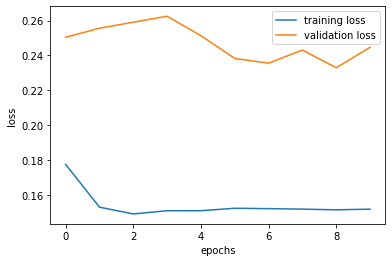

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
def eval_performance(model, test_loader):
  model.eval() #To ensure model is for eval
  predicted_labels = []
  true_labels = []
  with torch.no_grad(): #To prevent backpropogation
    for x1, x2, y in test_loader:
      x1 = x1.to(device)
      x2 = x2.to(device)

      output1, output2 = model(x1, x2)
      distance = F.pairwise_distance(output1, output2)
      pred = np.zeros(len(y))
      distance = distance.cpu().numpy()
      pred[distance>0.25] = 1

      true_labels.extend(y.numpy())
      predicted_labels.extend(pred)
  
  return true_labels, predicted_labels

In [ ]:
true_labels, predicted_labels = eval_performance(model, test_loader)

In [ ]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.49      0.62       850
           1       0.13      0.44      0.20       150

    accuracy                           0.48      1000
   macro avg       0.48      0.47      0.41      1000
weighted avg       0.73      0.48      0.56      1000



In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

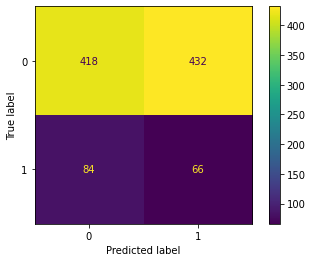

In [ ]:
disp.plot()